In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from math import isnan
import datetime
from datetime import datetime
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
%matplotlib inline


In [2]:
def prepare_dataframe(folder,course_id,subject=None):
    
    """
    возвращает таблицу с колонками: element_progress_id, hours_diff, user_id, module_is_achieved, 
                                    size_of_answer, size_of_review, rewiew_time, course_element_id
                                    id from solution_log
    """
    if subject is None:
        path = f'{folder}/{course_id}/'
    else:
        path = f'{folder}/{subject}/{course_id}/'
    try:
        solution_log = pd.read_csv(path+'solution_log.csv')
    except:
        raise Exception(f'No such file or directory',path,'solution_log.csv')
    
    
    solution_log['size_of_answer'] = solution_log['users_answer'].apply(lambda x: len(str(x)))
    solution_log['size_of_review'] = solution_log['review'].apply(lambda x: len(str(x)))

    solution_log = solution_log.dropna(subset=['review_time'])
    solution_log = solution_log.reset_index(drop=True)
    
    ###
    difference = []
    for i in range(len(solution_log['review_time'])):
        a = datetime.strptime(magic(solution_log['submission_time'][i]), '%Y %m %d %H:%M:%S')
        b = datetime.strptime(magic(solution_log['review_time'][i]), '%Y %m %d %H:%M:%S')
        difference.append(b - a)
    solution_log['time_of_expectation'] = difference
    solution_log = solution_log.drop(columns=['submission_time'])
    ###
    
    solution_log['hours_diff']=solution_log['time_of_expectation'].apply(lambda x: x.days*24+x.seconds//3600)
    pre_df = solution_log[['element_progress_id','hours_diff', 'size_of_answer', 'size_of_review', 'tries_count', 'review_time']]
    pre_df['id_from_sl'] = solution_log['id']
    pre_df['id']=pre_df['element_progress_id'].astype(int)
    ##pre_df = pre_df.drop(columns=['element_progress_id'])
    try:
        user_element_progress = pd.read_csv(path+'user_element_progress.csv')
    except:
        raise Exception(f'No such file or directory',path,'user_element_progress.csv')
    user_element_progress['id'] = user_element_progress['id'].astype(int)
    user_element_progress.reset_index(drop=True)
    user_element_progress = user_element_progress[['id','user_id', 'course_element_id']]
    
    try:
        user_module_progress = pd.read_csv(path+'user_module_progress.csv')
    except:
        raise Exception(f'No such file or directory',path,'user_module_progress.csv')
    user_module_progress['is_achieved'] = user_module_progress['is_achieved'].fillna(False).astype(int)
    user_module_progress = user_module_progress[['user_id','is_achieved']]
    
    df = pre_df.merge(user_element_progress).merge(user_module_progress, on='user_id').drop(columns='id')
    return df
def magic(date):
    date = date[:4]+' '+date[5:7]+' '+date[8:]       
    return date[:18]

In [3]:
subjects = ['math','physics','linguo']
coursers = [['293','294','295'], ['345','346'],['267','268']]
df = pd.DataFrame()
for s in enumerate(subjects):
        for c in coursers[s[0]]:
            tmp_df = prepare_dataframe(folder='courses_with_manual_check',subject = s[1],course_id = c)
            for i in tmp_df['user_id']:
                try:
                    if i in df['user_id']:
                        print('Alarm')
                except:
                    pass
            df=df.append(tmp_df, ignore_index=True)
new_coursers_id = [370,67,71,76,84,226,231,233,251,252,259,307,318]
for ID in new_coursers_id:
    tmp_df = prepare_dataframe(folder='new_courses',course_id = str(ID))
    for i in tmp_df['user_id']:
                try:
                    if i in df['user_id']:
                        print('Alarm')
                except:
                    pass
    df=df.append(tmp_df, ignore_index=True)
df = df.sort_values(by = ['user_id', 'review_time'])
df

/var/folders/n2/54qn21r52zn_m2w4tz54bty40000gn/T/ipykernel_52352/3685656577.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_df['id_from_sl'] = solution_log['id']
/var/folders/n2/54qn21r52zn_m2w4tz54bty40000gn/T/ipykernel_52352/3685656577.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_df['id']=pre_df['element_progress_id'].astype(int)


,element_progress_id,hours_diff,size_of_answer,size_of_review,tries_count,review_time,id_from_sl,user_id,course_element_id,is_achieved
17500,64815057,124,90,34,1,2020-10-28 00:14:03.228184,19424129,100119700110016452,9369,0
17498,64815054,157,90,34,1,2020-10-29 08:23:38.175426,19424077,100119700110016452,9366,0
17499,64815053,168,90,362,1,2020-10-29 20:11:57.338260,19424055,100119700110016452,9324,0
17501,67336056,40,90,34,1,2020-11-07 13:11:25.638969,20003446,100119700110016452,9576,0
17504,67919957,24,90,286,1,2020-11-10 19:23:48.168905,20147784,100119700110016452,9603,0
...,...,...,...,...,...,...,...,...,...,...
1389,93663732,41,2704,34,1,2021-05-20 07:08:06.808021,27882413,100120100111069319,3139,1
1410,93663731,43,5464,34,1,2021-05-20 08:42:02.612156,27881925,100120100111069319,4953,1
1404,93663735,39,2675,34,1,2021-05-24 08:48:10.425462,28072480,100120100111069319,4948,1
1398,93663733,20,90,34,1,2021-05-27 14:20:00.910940,28301677,100120100111069319,4100,1


In [29]:
def q_9(x):
    return np.quantile(x, 0.9) 
q_9.__name__ = '0.9 quantile'
df1 = df.groupby(['user_id']).agg({'hours_diff':['mean',q_9,'median','max','std','min'], 
                         'size_of_answer':['mean','std'], 
                         'size_of_review':['mean','std'],
                         'is_achieved':'max'})
df1.columns = ['_'.join(col) for col in df1.columns]
df1.reset_index(inplace=True)
df1

,user_id,hours_diff_mean,hours_diff_0.9 quantile,hours_diff_median,hours_diff_max,hours_diff_std,hours_diff_min,size_of_answer_mean,size_of_answer_std,size_of_review_mean,size_of_review_std,is_achieved_max
0,100119700110016452,81.285714,161.4,42.0,168,65.996753,14,90.000000,0.000000,236.714286,265.606673,0
1,100119700110094008,27.966667,66.2,21.0,133,29.143369,0,1948.566667,1927.468964,562.500000,744.164976,1
2,100119700110734353,75.844444,181.0,28.0,466,93.785528,0,107.288889,115.977392,243.644444,268.958780,1
3,100119700110754005,34.000000,73.6,24.0,182,32.991305,0,2997.564516,2486.847452,669.854839,638.884988,0
4,100119710111632285,47.172414,47.0,44.0,328,55.542821,1,229.034483,491.712640,492.517241,323.433656,0
...,...,...,...,...,...,...,...,...,...,...,...,...
602,100120090110770457,22.800000,38.0,21.0,178,23.495478,0,606.861538,905.417167,498.446154,800.527737,0
603,100120090111068504,15.303030,28.0,19.0,32,10.935849,0,90.000000,0.000000,295.606061,459.254895,1
604,100120090111080713,25.232558,43.8,24.0,47,12.881950,0,2684.511628,2708.074491,1078.325581,1244.025967,0
605,100120100111069319,21.623188,41.4,20.0,92,19.811688,0,1685.681159,1881.511779,574.666667,902.608926,1


In [30]:
df['less_48'] = df['hours_diff']<48
gdf = df.groupby('user_id').agg({'less_48':'sum','id_from_sl':'count'})
gdf['in_df'] = gdf['less_48']/gdf['id_from_sl'] >= 0.9
valid_indices = gdf[gdf['in_df']].index
valid_indices.values

array([100119710111632285, 100119750111014140, 100119770110738215,
       100119790110538904, 100119800111017177, 100119870111089972,
       100119920110029719, 100119930111128631, 100119970110112023,
       100119970111066436, 100120010110068331, 100120030110041863,
       100120030110045011, 100120030110045612, 100120030110066586,
       100120030110250173, 100120030110270102, 100120030110755270,
       100120030110771188, 100120040110008834, 100120040110011394,
       100120040110011849, 100120040110013196, 100120040110017807,
       100120040110021773, 100120040110023418, 100120040110033586,
       100120040110033958, 100120040110035772, 100120040110041279,
       100120040110043964, 100120040110045553, 100120040110046581,
       100120040110047914, 100120040110049495, 100120040110050088,
       100120040110075390, 100120040110088198, 100120040110098148,
       100120040110142926, 100120040110169041, 100120040110279406,
       100120040110280213, 100120040110286131, 100120040110292

In [31]:
df_for_train = df1[df1.user_id.isin(valid_indices.values)]

X = df_for_train.drop(columns=['user_id','is_achieved_max'])
print(X.shape)
y = df_for_train['is_achieved_max'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)


(361, 10)


In [58]:
grid = {'l2_leaf_reg':[3,5,7,9,11,15,4,6,8,10],
            'depth':[3,4,5,6,7],
            'learning_rate':np.linspace(0.45,0.6,15)
            }

In [59]:
cat_classifier = CatBoostClassifier(iterations=228,
                    custom_metric=['Precision','Recall']
                    ,random_seed=42
                    ,loss_function='Logloss',
                    eval_metric='F1',
                    verbose=False)

In [60]:
cat_classifier.grid_search(param_grid=grid,X=X_train,y=y_train, search_by_train_test_split=False, cv=5, plot=True,verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'params': {'depth': 3,
  'l2_leaf_reg': 15,
  'learning_rate': 0.46071428571428574},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
   

In [61]:
cat_classifier.get_params()

{'iterations': 299,
 'loss_function': 'Logloss',
 'random_seed': 42,
 'verbose': False,
 'custom_metric': ['Precision', 'Recall'],
 'eval_metric': 'F1',
 'depth': 3,
 'l2_leaf_reg': 15,
 'learning_rate': 0.46071428571428574}

In [62]:
cat_classifier.get_feature_importance(prettified=True)

,Feature Id,Importances
0,hours_diff_max,15.041508
1,size_of_answer_mean,13.423408
2,size_of_review_mean,12.242347
3,hours_diff_min,11.620908
4,hours_diff_std,10.282087
5,hours_diff_mean,9.813165
6,size_of_review_std,9.131639
7,size_of_answer_std,7.272796
8,hours_diff_0.9 quantile,5.813838
9,hours_diff_median,5.358304


In [63]:
preds = cat_classifier.predict(X_test)
metrics = pd.DataFrame(columns=['f1-score','precision','recall','ROC-AUC'],index=[0])
metrics['f1-score'] = f1_score(y_test, preds)
metrics['precision'] = precision_score(y_test, preds)
metrics['recall'] = recall_score(y_test, preds)
metrics['ROC-AUC'] = roc_auc_score(y_test,cat_classifier.predict_proba(X_test)[:,1])
metrics

,f1-score,precision,recall,ROC-AUC
0,0.655172,0.678571,0.633333,0.762016


In [64]:
fpr, tpr, thresholds = get_roc_curve(model=cat_classifier, 
              data=Pool(X_test,y_test), 
              thread_count=4, 
              plot=False)

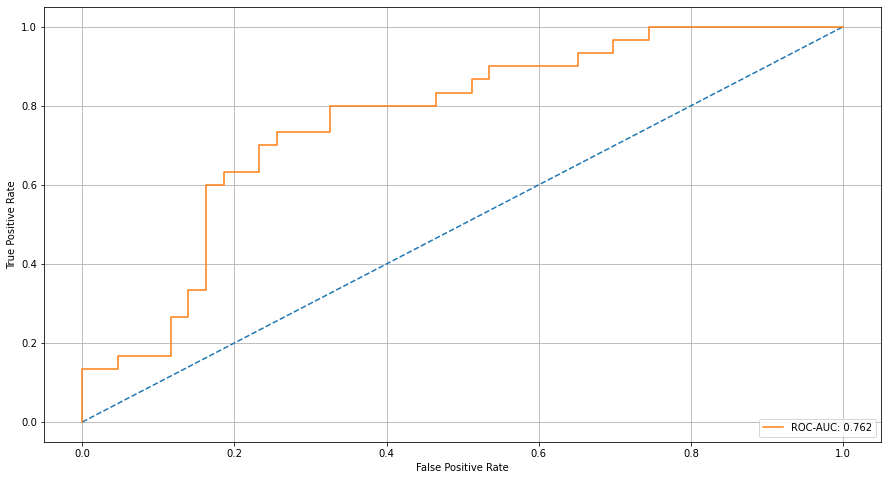

In [65]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(fpr,fpr,'--')
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, label=f'ROC-AUC: {roc_auc_score(y_test,cat_classifier.predict_proba(X_test)[:,1]):.3f}')
plt.grid(True)
plt.show()

In [55]:
metrics.to_csv('metrics.csv')